In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math as m
import itertools
import seaborn as sns
import random 

## Input

In [3]:
df = pd.read_csv("dataset/titanic.csv")
target = "Survived" 
target_objective = "binary","maximise","minimise","multiple, maximise / minimise", "number_of_rows" "etc" 
categorical_columns = ['Pclass','Sex','SibSp','Embarked']

## Basic KPIs

In [4]:
df_shape = df.shape
df_shape

(891, 12)

In [5]:
list_columns = df.columns.to_list()
list_columns

['PassengerId',
 'Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked']

In [6]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


,Survived
0,549
1,342


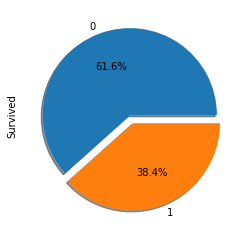

In [7]:
# Case of categorical classification
display(pd.DataFrame(df[target].value_counts()))
df[target].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',shadow=True)
plt.show()

Type of data:

- numerical continuous (floats)
- numerical discreet (integer)
- categorical (contain letters) 
    - Of importance if the number of unique values of the categorical is not to small compared 
    to the numbuer of unique ID (case where almost all ID have the same category) and not to high (case where each ID has a unique category). Need to rank by 
- categorical ordinal - ordered category (is categorical - and .

## Missing Values

In [11]:
def missing_values(df, df_shape, list_columns):
    '''input : 
    - dataframe: full pandas dataframe
    - tuple: main dataframe shape
    - list: dataframe columns 
    - floats: threshold ratio of missing value acceptable for ID column
    - floats: threshold ratio of missing value acceptable for all other column
    
    output: 
    - string - Name of the column to use for counts 
    - Boolean - True if too many missing value, 20% threshold met, False otherwise.
    - dictionnary - missing value dict {column name : number of missing values}'''
    
    # Threshold of missing values that the main col used for groupby count must meet to raise an alert
    threshold_main_col = 0.01
    # Threshold of missing values that the other colmust meet to raise an alert
    threshold_other_col = 0.1
    
    missing_val_serie = df.isnull().sum().sort_values()
    col = missing_val_serie.index[0]
    number_of_missing_value_main_col = missing_val_serie[0]
    ratio = number_of_missing_value_main_col / df_shape[0]
    threhold_met = False
    if ratio >= threshold_main_col:
        threhold_met = True 
    
    col_with_missing_value = [col for col in list_columns if df[col].isnull().sum()/df_shape[0] > threshold_other_col] 
    
    return col,threhold_met,missing_val_serie.to_dict(),col_with_missing_value

In [12]:
id_col,threshold_met,serie,col_with_missing_value = missing_values(df,df_shape,list_columns)

****

In [13]:
df_groupby = pd.DataFrame(df.groupby(by = ['Sex',target])[id_col].count()).rename({id_col:"count"},axis =1)
df_groupby.reset_index(level = -1,inplace = True)
df_groupby

,Survived,count
Sex,,
female,0,81
female,1,233
male,0,468
male,1,109


## Entropy Calculation

 For categorical variables

In [14]:
def entropy(df_groupby, target_col, base=2):
    """input: 
    - dataframe : groupby dataframe 
    - target_col : string corresponding to the column that we want to classify/study
    - list : splitting criteria, usually the name of the columns used to proceed the groupby
    - integer : base of the logarithm used for entropy calculation
    output:
    - entropy value of the splitting criteria belonging to [0-1] Goal is to reach a low entropy, with a low diversity.
    
    entropy calculation inspired from here https://towardsdatascience.com/entropy-how-decision-trees-make-decisions-2946b9c18c8
        """ 
    total_entropy = 0
    count_total = df_groupby['count'].sum()
    
    # Case where the splitting criteria is categorical 
    list_splited_groups = list(df_groupby.index.unique())
    #list_splited_groups = list(df_groupby[splitting_criteria].unique()) # Used to be this, splitting criteria was inputed
    
    # Iterating over the various groups
    for splitting_index in list_splited_groups:
        df_splitted = df_groupby.loc[[splitting_index]]
        #df_splitted = df_groupby[df_groupby[splitting_criteria] == splitting_index] # Used to be this 
        total = df_splitted['count'].sum()
        
        # Case where the target variable is categorical
        # Iterating over the different target classes within the group
        entropy_group = 0
        for target_value in df_splitted[target_col].unique():
            count = df_splitted[df_splitted[target_col] == target_value]['count'].iloc[0]
            entropy_group -= (count/total)*m.log(count/total,base)
            
        total_entropy += entropy_group*(total/count_total)
    
    return total_entropy

In [15]:
total_entropy = entropy(df_groupby, target_col = target, base=2)
total_entropy

0.7430477952150327

## Feature combination

- need to find a way to find the type of columns (i.e. categorical, numerical etc)
- need to find a way to calculate correlation with numerical colums with respect to the target value, whether it's categorical like in our case or sales / visits (in the future).

In [16]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [17]:
def categorical_feature_combinations(main_df, id_col, categorical_col):

    dic_features_entropy = {}
    
    # Iterating over all base categorical features
    for feature in categorical_col:
        df_groupby = pd.DataFrame(main_df.groupby(by = [feature,target])[id_col].count())
        df_groupby.rename({id_col:"count"},axis =1,inplace = True)
        df_groupby.reset_index(level = -1,inplace = True)
        dic_features_entropy[feature] = entropy(df_groupby, target_col = target, base=2)
    
    # Iterating over all combination of categorical features
    for combination_of_feature in itertools.combinations(categorical_columns, 2):
        df_groupby = pd.DataFrame(main_df.groupby(by = [i for i in combination_of_feature + (target,)])[id_col].count()).rename({id_col:"count"},axis =1)
        df_groupby.rename({id_col:"count"},axis =1,inplace = True)
        df_groupby.reset_index(level = -1,inplace = True)
        dic_features_entropy["_:_".join([i for i in combination_of_feature])] = entropy(df_groupby, target_col = target, base=2)
        
    return dic_features_entropy

In [18]:
dic_features_entropy = categorical_feature_combinations(df,id_col,categorical_columns)
dic_features_entropy

{'Pclass': 0.8768768565796353,
 'Sex': 0.7430477952150327,
 'SibSp': 0.927241580536937,
 'Embarked': 0.938768034589886,
 'Pclass_:_Sex': 0.6461338032372405,
 'Pclass_:_SibSp': 0.85556049583231,
 'Pclass_:_Embarked': 0.8598865174188444,
 'Sex_:_SibSp': 0.7100494751548546,
 'Sex_:_Embarked': 0.7248383457345646,
 'SibSp_:_Embarked': 0.9052671878778508}

In [19]:
df_features_entropy = pd.DataFrame(data = dic_features_entropy.values(),index = dic_features_entropy.keys(),columns = ['entropy']).sort_values(by = 'entropy')
df_features_entropy

,entropy
Pclass_:_Sex,0.646134
Sex_:_SibSp,0.710049
Sex_:_Embarked,0.724838
Sex,0.743048
Pclass_:_SibSp,0.855560
Pclass_:_Embarked,0.859887
Pclass,0.876877
SibSp_:_Embarked,0.905267
SibSp,0.927242
Embarked,0.938768


- Concretely showing the features that distinguish the most groups with respect to the target variable 
- Need to account for proportions

## Visualisation 

In [70]:
def visualise(feature_entropy_ranking):
    # Create dataframe to plot
    df_visu = pd.DataFrame(df.groupby(by = list(df_features_entropy.index[feature_entropy_ranking].split("_:_"))+ [target])[id_col].count())
    # reset indexes
    df_visu = df_visu.sort_values(by = id_col).reset_index()
    # create a column
    df_visu['visu_axis'] = df_visu.drop([id_col,target], axis=1).astype(str).apply('_'.join, axis=1)
    
    for target_value in df_visu[target].unique():
        # color
        r,g,b = random.random(),random.random(),random.random()
        # df to plot
        df_to_plot = df_visu[df_visu[target]==target_value]
        objects = tuple(df_to_plot['visu_axis'])
        y_pos = np.arange(len(objects))
        performance = list(df_to_plot[id_col])
        # plotting
        plt.bar(y_pos, performance, align='center', color = (r,g,b), alpha=0.5)
        plt.xticks(y_pos, objects, rotation='vertical')
        plt.ylabel('Count')
        plt.legend(str(target_value))
        plt.title(" ".join([str(target_value), df_features_entropy.index[feature_entropy_ranking]]))
        print(i," ".join([str(target_value), df_features_entropy.index[feature_entropy_ranking]]))
        plt.legend(str(target_value))
        plt.show()
    
    print('------------------------------------------------------------------------------------------------')
    return df_visu

0 0 Pclass_:_Sex


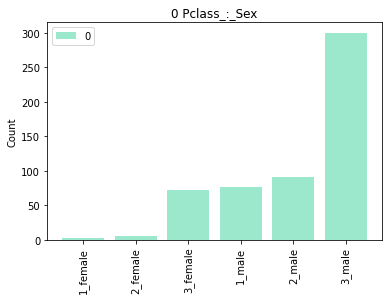

0 1 Pclass_:_Sex


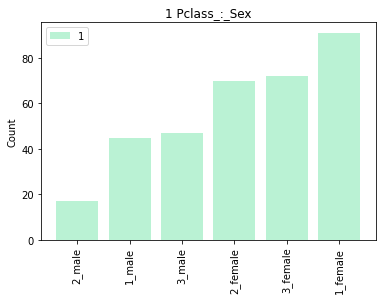

------------------------------------------------------------------------------------------------
1 1 Sex_:_SibSp


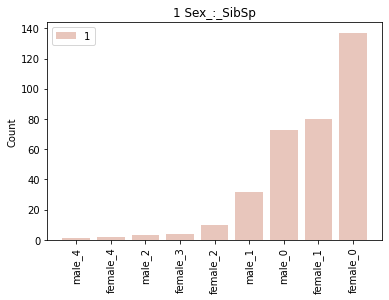

1 0 Sex_:_SibSp


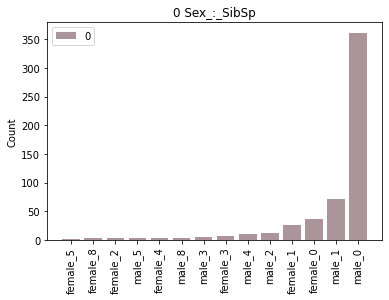

------------------------------------------------------------------------------------------------
2 1 Sex_:_Embarked


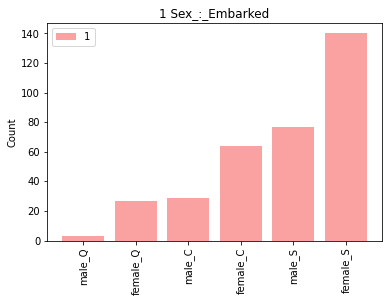

2 0 Sex_:_Embarked


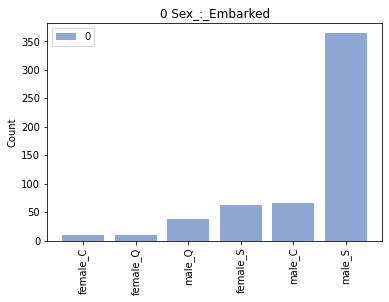

------------------------------------------------------------------------------------------------
3 0 Sex


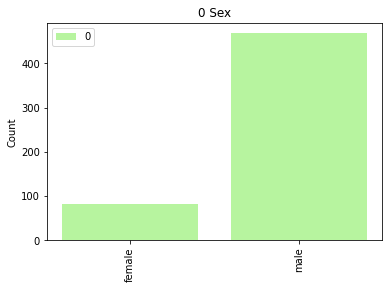

3 1 Sex


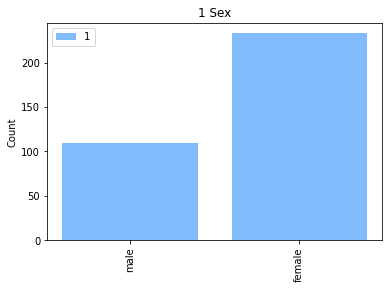

------------------------------------------------------------------------------------------------
4 1 Pclass_:_SibSp


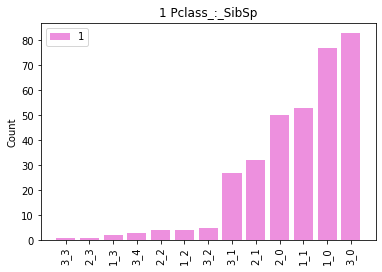

4 0 Pclass_:_SibSp


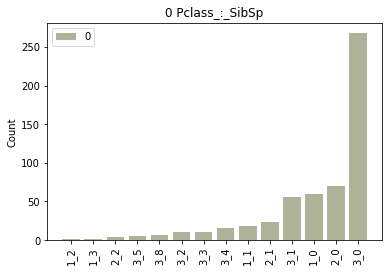

------------------------------------------------------------------------------------------------


In [71]:
for i in range(0,5):
    visualise(i)

## Numerical Values

In [72]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [73]:
df[['Survived','Age','Fare']].head(10)

,Survived,Age,Fare
0,0,22.0,7.2500
1,1,38.0,71.2833
2,1,26.0,7.9250
3,1,35.0,53.1000
4,0,35.0,8.0500
5,0,NaN,8.4583
6,0,54.0,51.8625
7,0,2.0,21.0750
8,1,27.0,11.1333
9,1,14.0,30.0708


### Main call

- Need to call the missing value
- Then the Entropu
- Then the feature combination
- Then visualisation

In [ ]:
# To Do: Library deployment
# To Do: Feature extractor (text)
# To Do: Numerical Value correlation / growth
# To Do: Numerical target value 
# To Do: Visit Maximisation target value
# To Do: Server visualisation (Dask)
# To Do: Large Data Frame handling / Paralization
# TODO: Replace missing values strat? 
# TODO: Target is not a column that we try to maximise, minimise or find correlation to, but rather a number of rows
# TODO: Handle entropy calculation when the target is not categorical